## Natural Language Processing with Disaster Tweets

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this projects we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

### Imports Libraries

In [1]:
"""
import nltk
nltk.download('wordnet')
"""

"\nimport nltk\nnltk.download('wordnet')\n"

In [2]:
#!pip install wordcloud

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

### Read and Load the Data

In [4]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### A Quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [7]:
df_train[df_train["target"]==0]["text"].values[1]

'I love fruits'

And one that is:

In [8]:
df_train[df_train["target"]==1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [9]:
print("Training Set Shape : {}".format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape : (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


## Explore the Dataset

### Handling Missing Values

In [10]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Text is all non-null. Only a small percentage of tweets have no keyword. Location has much more null values.

In [12]:
# Fill null values
for col in ['keyword','location']:
    df_train[col] = df_train[col].fillna('None')
    df_test[col] = df_test[col].fillna('None')

df_train.isnull().sum(), df_test.isnull().sum()

(id          0
 keyword     0
 location    0
 text        0
 target      0
 dtype: int64,
 id          0
 keyword     0
 location    0
 text        0
 dtype: int64)

### Finding Duplicate Values

In this section you will identify duplicate values in the dataset.

Find how many duplicate rows exist in the dataframe.

In [13]:
df_train.duplicated().sum()

0

In [14]:
df_test.duplicated().sum()

0

In [15]:
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

## Preprocessing of Text

### Function to Remove Emojis

In [16]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

### Fucntion to Convert text to lowercase, remove (/r, /n characters), URLs, non-utf characters, Numbers, punctuations, stopwords

In [17]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove non-utf characters
    text = text.encode('ascii', 'ignore').decode()

    # Remove numbers and punctuations
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    # Remove \r and \n characters
    text = text.replace('\r', '').replace('\n', '')

    return text


### Function to remove contractions

In [18]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

### Function to Clean Hashtags

In [19]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

### Function to Filter Special Characters such as $, &

In [20]:
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

### Function to remove mutiple sequence spaces

In [21]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

### Function to apply stemming to words

In [22]:
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

### Function to apply lemmatization to words

In [23]:
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

### Function to Preprocess the text by applying all above functions

In [24]:
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = clean_text(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [25]:
df_train["cleaned_text"] = df_train["text"].apply(preprocess)
df_train.head()

,id,keyword,location,text,target,cleaned_text
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv u
1,4,None,None,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,None,None,All residents asked to 'shelter in place' are ...,1,resid ask ishelt place notifi offic evacu shel...
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [26]:
df_test["cleaned_text"] = df_test["text"].apply(preprocess)
df_test.head()

,id,keyword,location,text,cleaned_text
0,0,None,None,Just happened a terrible car crash,happen terribl car crash
1,2,None,None,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon
2,3,None,None,"there is a forest fire at spot pond, geese are...",forest fire spot pond gee flee across street save
3,9,None,None,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,None,None,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


### Dealing with Duplicates

In [27]:
df_train["cleaned_text"].duplicated().sum()

770

In [28]:
df_test["cleaned_text"].duplicated().sum()

189

In [29]:
df_train.drop_duplicates("cleaned_text", inplace=True)

df_train["cleaned_text"].duplicated().sum()

0

In [30]:
df_test.drop_duplicates("cleaned_text", inplace=True)

df_test["cleaned_text"].duplicated().sum()

0

### Tokenization

In [31]:
df_train['tweet_list'] = df_train['cleaned_text'].apply(word_tokenize)
df_train.head()

,id,keyword,location,text,target,cleaned_text,tweet_list
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv u,"[deed, reason, earthquak, may, allah, forgiv, u]"
1,4,None,None,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,"[forest, fire, near, la, rong, sask, canada]"
2,5,None,None,All residents asked to 'shelter in place' are ...,1,resid ask ishelt place notifi offic evacu shel...,"[resid, ask, ishelt, place, notifi, offic, eva..."
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california,"[peopl, receiv, wildfir, evacu, order, califor..."
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,"[got, sent, photo, rubi, alaska, smoke, wildfi..."


In [32]:
df_test['tweet_list'] = df_test['cleaned_text'].apply(word_tokenize)
df_test.head()

,id,keyword,location,text,cleaned_text,tweet_list
0,0,None,None,Just happened a terrible car crash,happen terribl car crash,"[happen, terribl, car, crash]"
1,2,None,None,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon,"[heard, earthquak, differ, citi, stay, safe, e..."
2,3,None,None,"there is a forest fire at spot pond, geese are...",forest fire spot pond gee flee across street save,"[forest, fire, spot, pond, gee, flee, across, ..."
3,9,None,None,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir,"[apocalyps, light, spokan, wildfir]"
4,11,None,None,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]"


### Checking length of various tweet texts

In [33]:
text_len = []
for text in df_train.tweet_list:
    tweet_len = len(text)
    text_len.append(tweet_len)
df_train['text_len'] = text_len

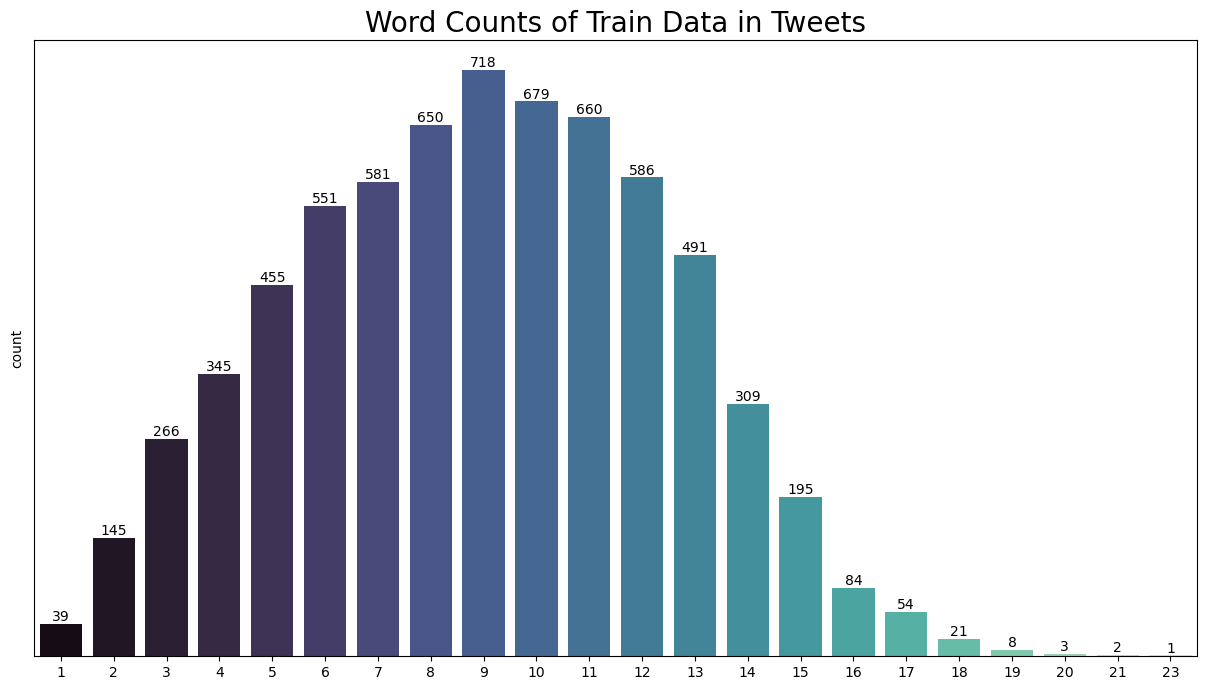

In [34]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=df_train, palette='mako')
plt.title('Word Counts of Train Data in Tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### Removing text without words

In [35]:
df_train = df_train[df_train['text_len']!=0]
df_train.shape

(6843, 8)

In [36]:
text_len = []
for text in df_test.tweet_list:
    tweet_len = len(text)
    text_len.append(tweet_len)
df_test['text_len'] = text_len


df_test = df_test[df_test['text_len']!=0]
df_test.shape

(3073, 7)

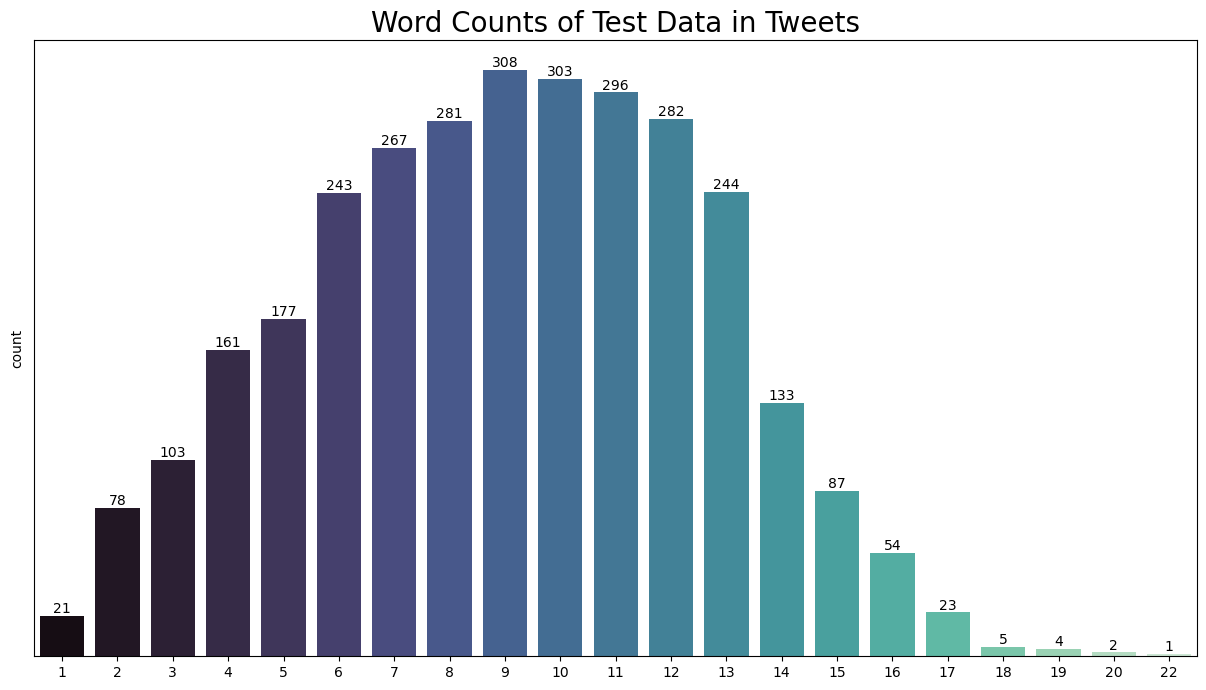

In [37]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=df_test, palette='mako')
plt.title('Word Counts of Test Data in Tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

## Exploratory Data Analysis & Visualization

### Class Distributions

Create a bar plot of the class distribution

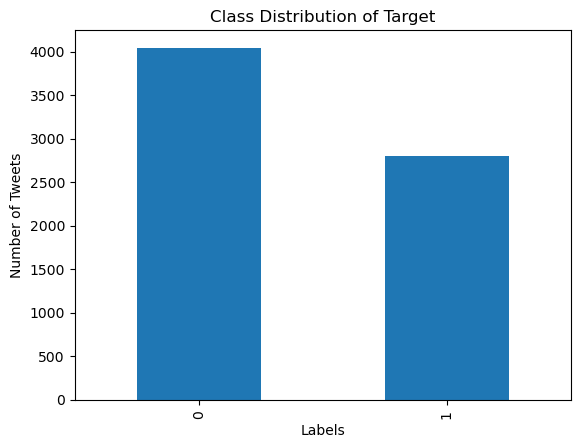

In [38]:
class_counts = df_train['target'].value_counts()
class_counts.plot(kind='bar')

plt.title('Class Distribution of Target')
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

### Checking Keyword

Check number of unique keywords, and whether they are the same for train and test sets

In [39]:
print (df_train.keyword.nunique(), df_test.keyword.nunique())
print (set(df_train.keyword.unique()) - set(df_test.keyword.unique()))

222 222
set()


Train and test have the same set of keywords

### Top 10 Keyword

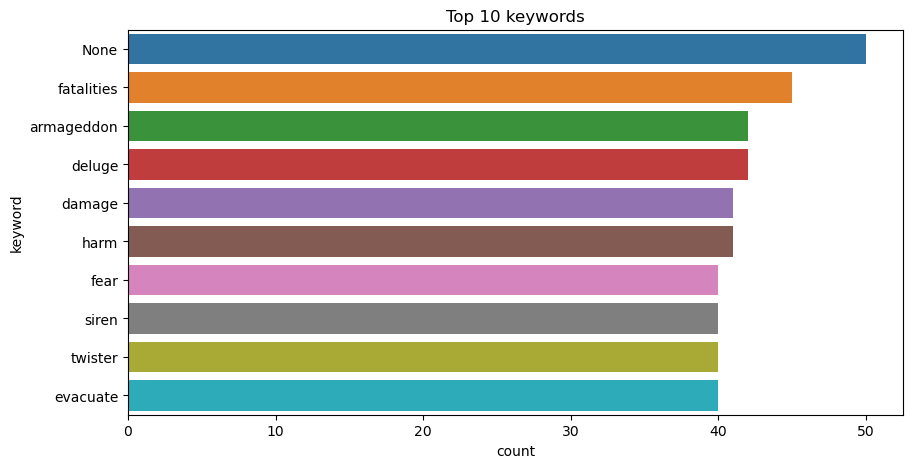

In [40]:
# Most common 10 keywords
plt.figure(figsize=(10,5))
sns.countplot(y=df_train.keyword, order = df_train.keyword.value_counts().iloc[:10].index)
plt.title('Top 10 keywords')
plt.show()
# train.keyword.value_counts().head(10)

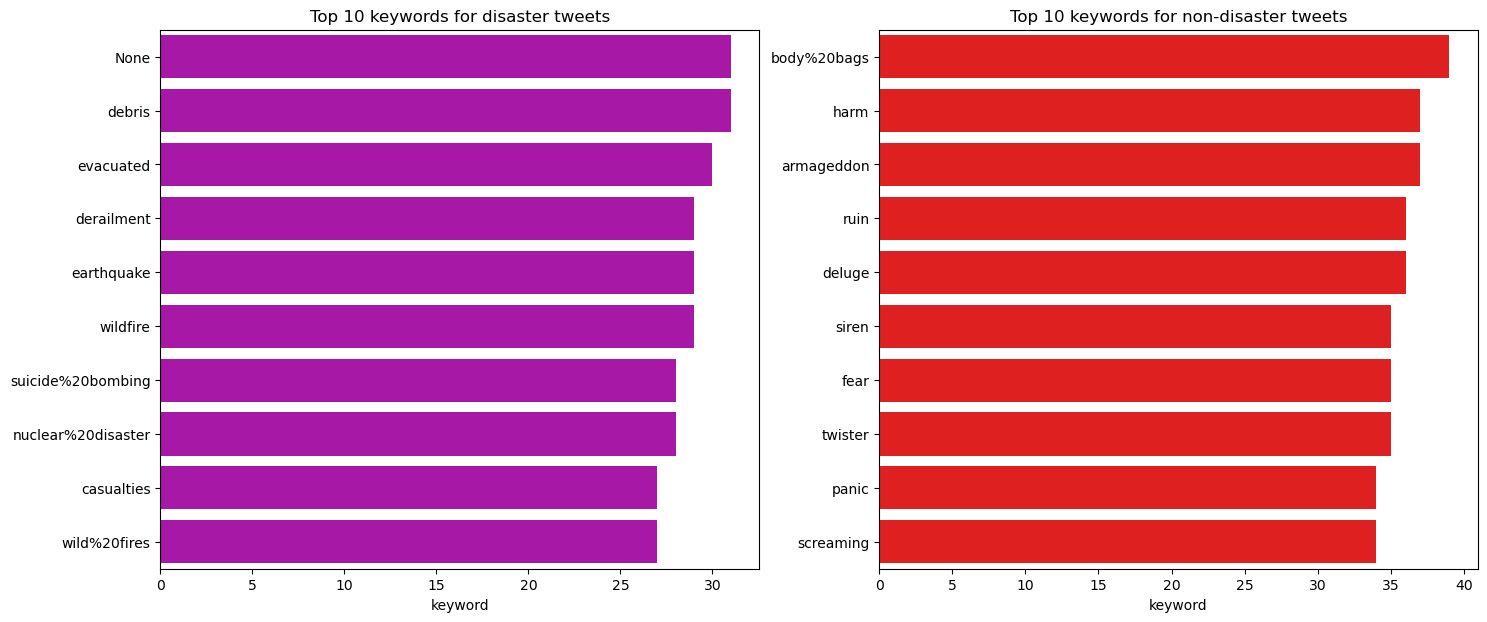

In [41]:
kw_d = df_train[df_train.target==1].keyword.value_counts().head(10)
kw_nd = df_train[df_train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(17,7))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='m')
plt.title('Top 10 keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='r')
plt.title('Top 10 keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

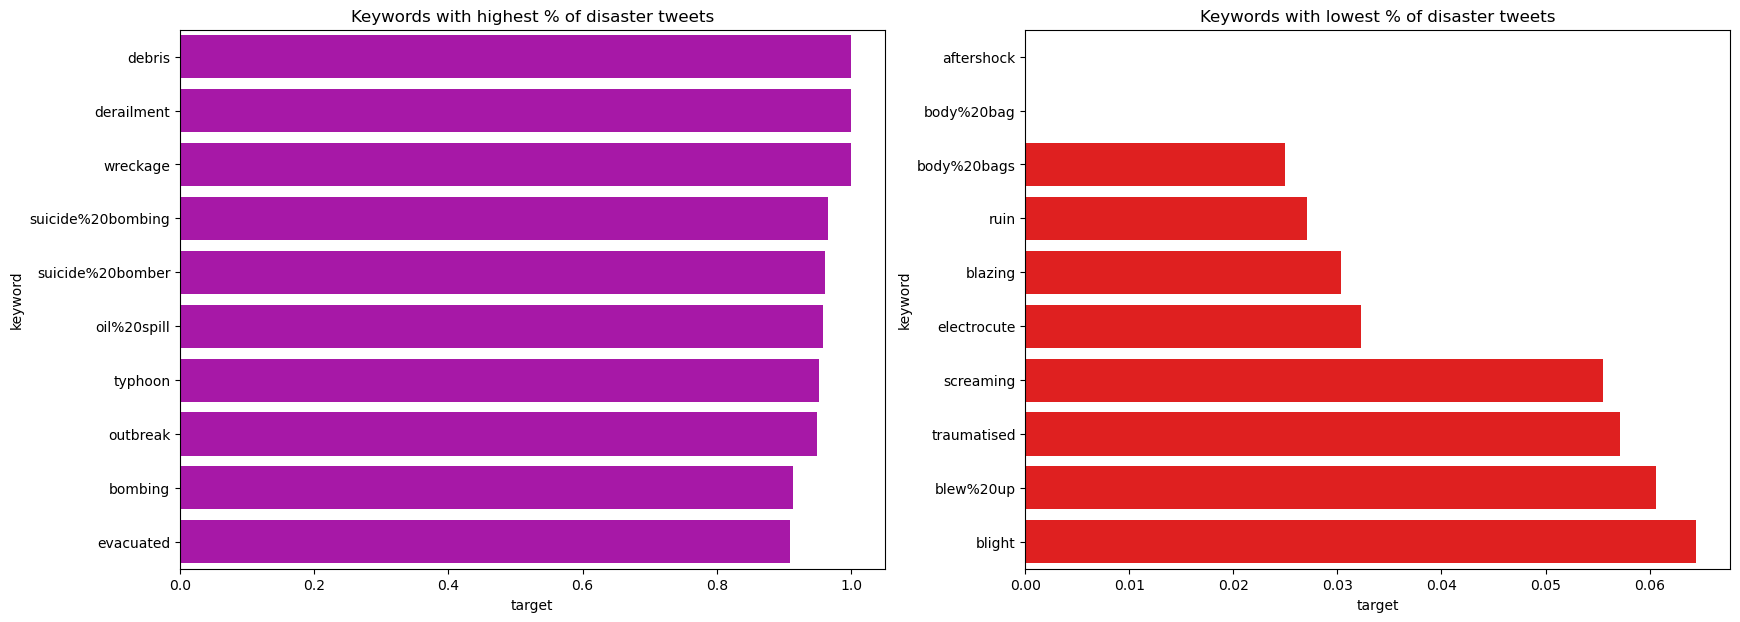

In [42]:
top_d = df_train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = df_train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(20,7))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='m')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='r')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

### Top 10 Locations

Check number of unique keywords and locations

In [43]:
print (df_train.location.nunique(), df_test.location.nunique())

3161 1548


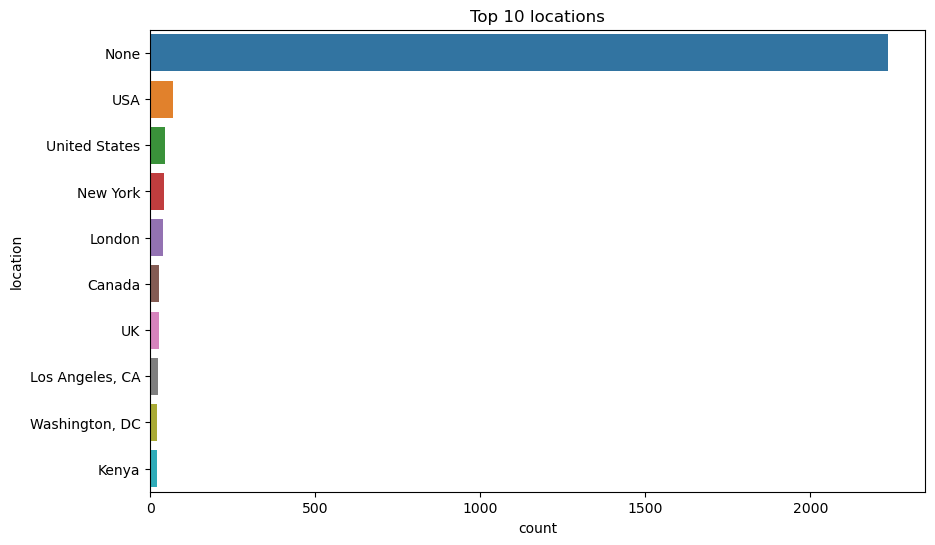

In [44]:
# Most common 10 locations
plt.figure(figsize=(10,6))
sns.countplot(y=df_train.location, order = df_train.location.value_counts().iloc[:10].index)
plt.title('Top 10 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster and non disaster tweets for common locations.

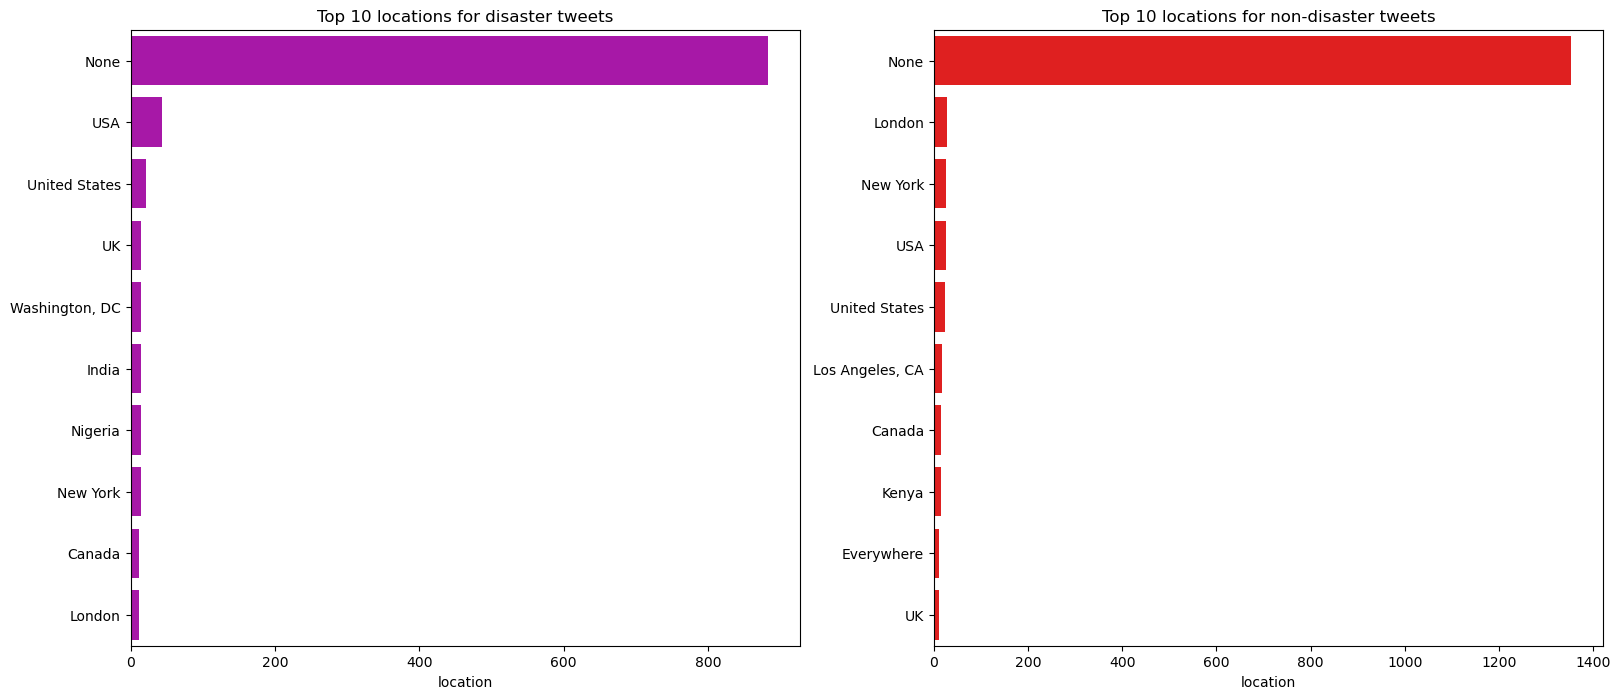

In [45]:
loc_d = df_train[df_train.target==1].location.value_counts().head(10)
loc_nd = df_train[df_train.target==0].location.value_counts().head(10)

plt.figure(figsize=(19,8))
plt.subplot(121)
sns.barplot(loc_d, loc_d.index, color='m')
plt.title('Top 10 locations for disaster tweets')
plt.subplot(122)
sns.barplot(loc_nd, loc_nd.index, color='r')
plt.title('Top 10 locations for non-disaster tweets')
plt.show()

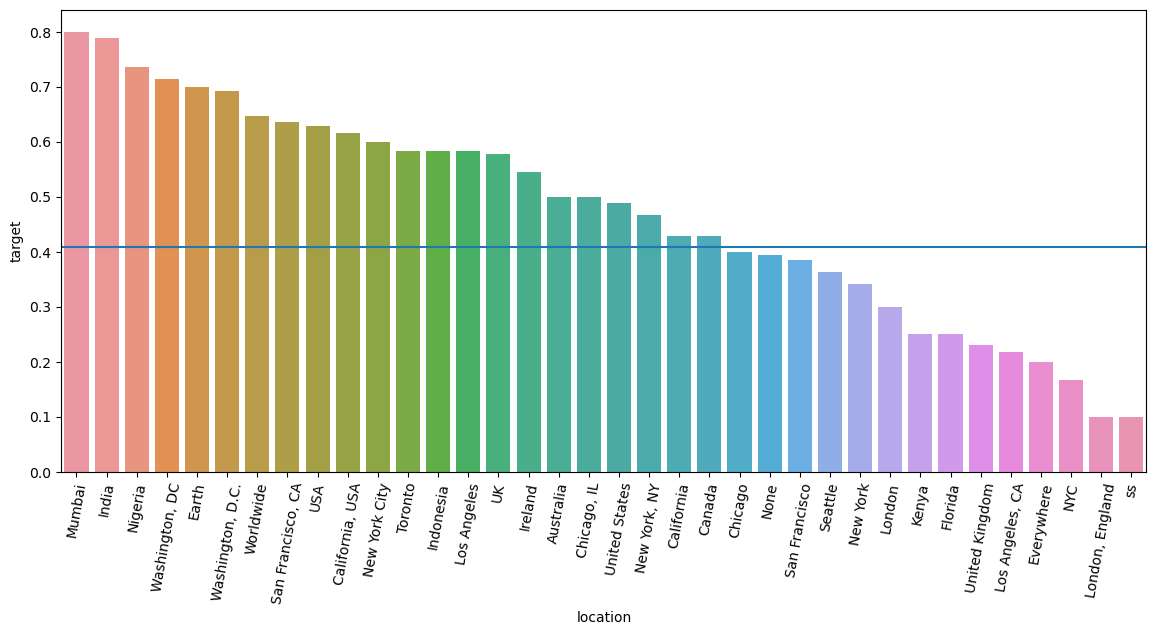

In [46]:
raw_loc = df_train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = df_train[df_train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(df_train.target))
plt.xticks(rotation=80)
plt.show()

The top 3 locations with highest % of disaster tweets are __Mumbai, Inida, and Nigeria__. As the location data is not clean, we see some interesting cases, such as __'London, UK' saw a higher-than-average % of disaster tweets, but 'London' is below average__. We try to clean up the location and see if there is any difference

In [47]:
def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
df_train['location_clean'] = df_train['location'].apply(lambda x: clean_loc(str(x)))
df_test['location_clean'] = df_test['location'].apply(lambda x: clean_loc(str(x)))

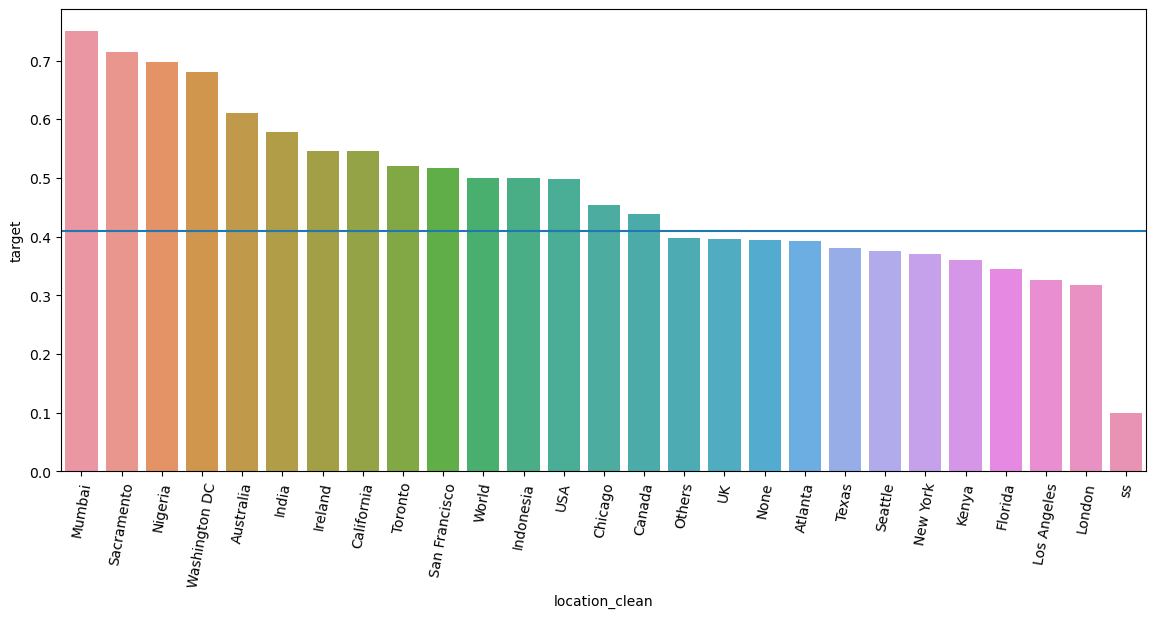

In [48]:
top_10 = df_train.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_10.index, y=top_10)
plt.axhline(np.mean(df_train.target))
plt.xticks(rotation=80)
plt.show()

Mumbai and Nigeria are still on the top. Other than the strange 'ss', London and New York made the bottom of % of disaster tweets.

### Top 10 Words

In [49]:
# Concatenate all tweet texts into a single string
all_text = ' '.join(df_train['cleaned_text'].values)

# Remove URLs, mentions, and hashtags from the text
all_text = re.sub(r'http\S+', '', all_text)
all_text = re.sub(r'@\S+', '', all_text)
all_text = re.sub(r'#\S+', '', all_text)

# Split the text into individual words
words = all_text.split()

In [50]:
# Remove stop words
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]

In [51]:
# Count the frequency of each word
word_counts = Counter(words)
top_words = word_counts.most_common(100)
top_words

[('like', 393),
 ('fire', 332),
 ('get', 287),
 ('amp', 287),
 ('u', 243),
 ('go', 198),
 ('one', 197),
 ('bomb', 190),
 ('would', 188),
 ('peopl', 183),
 ('new', 180),
 ('via', 180),
 ('time', 169),
 ('news', 166),
 ('burn', 165),
 ('emerg', 156),
 ('flood', 150),
 ('video', 150),
 ('kill', 145),
 ('crash', 144),
 ('day', 141),
 ('build', 140),
 ('look', 140),
 ('say', 137),
 ('year', 134),
 ('love', 129),
 ('polic', 129),
 ('bodi', 129),
 ('see', 128),
 ('make', 126),
 ('attack', 125),
 ('got', 123),
 ('disast', 123),
 ('come', 123),
 ('evacu', 122),
 ('know', 121),
 ('back', 119),
 ('storm', 119),
 ('want', 113),
 ('scream', 112),
 ('still', 110),
 ('man', 108),
 ('death', 107),
 ('world', 107),
 ('bag', 105),
 ('collaps', 103),
 ('car', 101),
 ('first', 101),
 ('train', 101),
 ('think', 101),
 ('derail', 101),
 ('home', 100),
 ('need', 100),
 ('rt', 99),
 ('let', 98),
 ('fatal', 98),
 ('live', 97),
 ('wreck', 97),
 ('drown', 97),
 ('california', 95),
 ('nuclear', 95),
 ('youtub', 9

### Create a bar chart of the most common Top 10 words

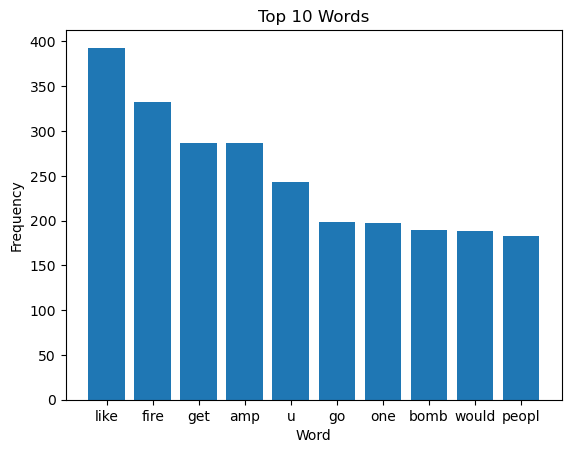

In [52]:
top_words = word_counts.most_common(10) # Change the number to show more/less words
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 10 Words')
plt.show()

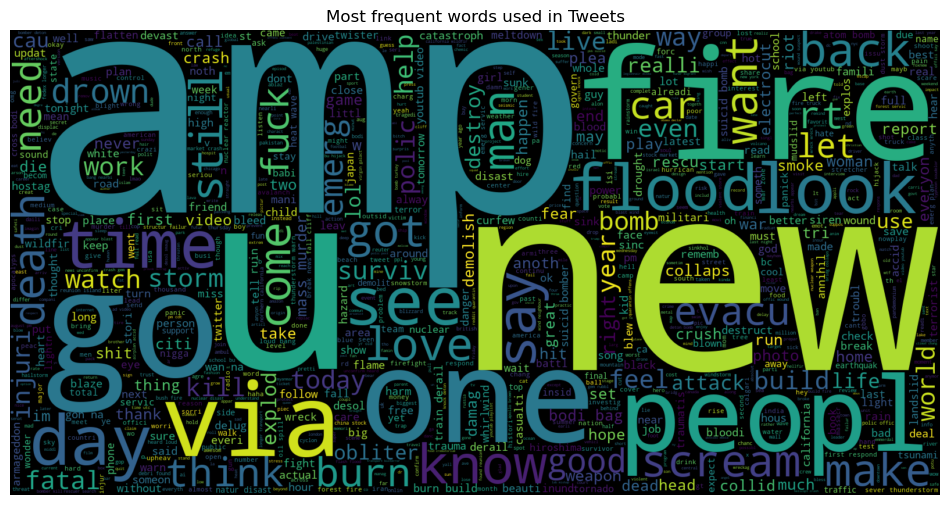

In [53]:
from wordcloud import WordCloud

text = ' '.join([word for word in df_train['cleaned_text']])
plt.figure(figsize=(12,8), facecolor='None')

wordcloud = WordCloud(max_words=1000, width=1600, height=800).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words used in Tweets', fontsize=12)
plt.show()

In [54]:
df_train.corr()['target'].sort_values()

id          0.042409
text_len    0.128845
target      1.000000
Name: target, dtype: float64

In [55]:
df_train.head()

,id,keyword,location,text,target,cleaned_text,tweet_list,text_len,location_clean
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv u,"[deed, reason, earthquak, may, allah, forgiv, u]",7,None
1,4,None,None,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,"[forest, fire, near, la, rong, sask, canada]",7,None
2,5,None,None,All residents asked to 'shelter in place' are ...,1,resid ask ishelt place notifi offic evacu shel...,"[resid, ask, ishelt, place, notifi, offic, eva...",11,None
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california,"[peopl, receiv, wildfir, evacu, order, califor...",6,None
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,"[got, sent, photo, rubi, alaska, smoke, wildfi...",9,None


### Building Models

In [56]:
df_train.shape, df_test.shape

((6843, 9), (3073, 8))

Create a bag of words using CountVectorizer

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# create a bag of words using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_train['cleaned_text'])


# split the data into training and testing sets
y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

Train a logistic regression model

In [58]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

# make predictions on the test set
y_pred = clf.predict(X_test)

# evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7918188458729
              precision    recall  f1-score   support

           0       0.79      0.88      0.84       820
           1       0.79      0.66      0.72       549

    accuracy                           0.79      1369
   macro avg       0.79      0.77      0.78      1369
weighted avg       0.79      0.79      0.79      1369



In [59]:
from sklearn.svm import SVC
# Create SVM classifier
svm_model = SVC()

# Train the model on the training data
svm_model.fit(X_train, y_train)

# Predict the labels for the testing data
y_pred = svm_model.predict(X_test)

# evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.789627465303141
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       820
           1       0.83      0.60      0.70       549

    accuracy                           0.79      1369
   macro avg       0.80      0.76      0.77      1369
weighted avg       0.80      0.79      0.78      1369



In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [61]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_train['cleaned_text'], df_train['target'], test_size=0.2, random_state=42)


In [62]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# Convert the text to sequences and pad them
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)


In [63]:
# Set up the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=100),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [64]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20
172/172 [==============================] - 42s 214ms/step - loss: 0.5586 - accuracy: 0.7106
Epoch 2/20
172/172 [==============================] - 36s 210ms/step - loss: 0.3098 - accuracy: 0.8716
Epoch 3/20
172/172 [==============================] - 36s 212ms/step - loss: 0.1760 - accuracy: 0.9311
Epoch 4/20
172/172 [==============================] - 37s 217ms/step - loss: 0.0981 - accuracy: 0.9658
Epoch 5/20
172/172 [==============================] - 38s 222ms/step - loss: 0.0666 - accuracy: 0.9768
Epoch 6/20
172/172 [==============================] - 37s 215ms/step - loss: 0.0386 - accuracy: 0.9874
Epoch 7/20
172/172 [==============================] - 31s 179ms/step - loss: 0.0280 - accuracy: 0.9907
Epoch 8/20
172/172 [==============================] - 28s 163ms/step - loss: 0.0208 - accuracy: 0.9934
Epoch 9/20
172/172 [==============================] - 29s 170ms/step - loss: 0.0161 - accuracy: 0.9945
Epoch 10/20
172/172 [==============================] - 31s 181ms/step - l

In [65]:
# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


43/43 [==============================] - 2s 23ms/step - loss: 1.9401 - accuracy: 0.7246
Test loss: 1.9400619268417358
Test accuracy: 0.724616527557373


### Submission

In [66]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [70]:
X_test = vectorizer.transform(df_test['cleaned_text'])

In [81]:
y_test_pred = clf.predict(X_test)

In [82]:
df_submission = pd.DataFrame({'id': df_test['id'], 'target': y_test_pred})
df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [83]:
df_submission.to_csv('submission.csv', index=False)
df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
